# Figure Production

This notebook contains the code to reproduce figures presented in the paper "Leveraging Large Language Models for Career Mobility Analysis: A Study of Gender, Race, and Job Change Using U.S. Online Resume Profiles." 

__Important Note For Reproducibility__

* The figures were developed using a proprietary, licensed commercial dataset (Lightcast data). The raw data files are NOT included in this repository and cannot be publicly shared.
* The file names for the data and figures used in the code are placeholders. To run this notebook, users must substitute them with their own compatible raw data files.

# Career Growth Rate Bar Plot

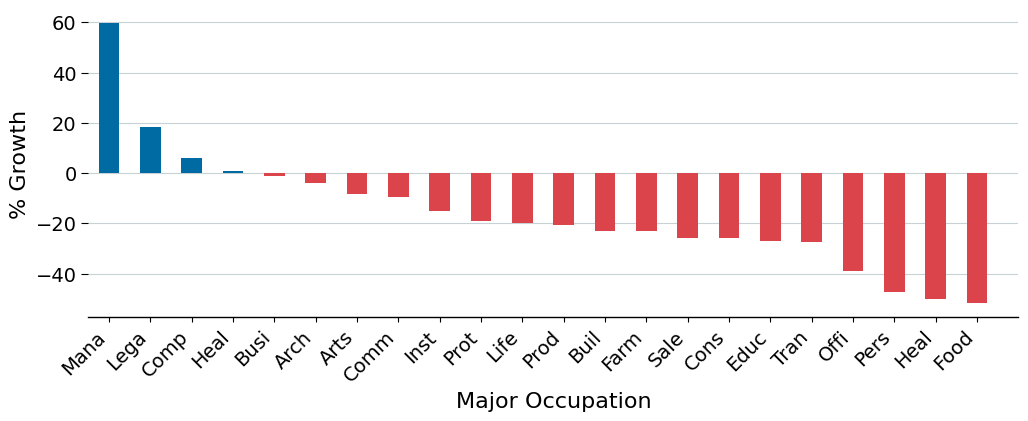

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("../data/occupation_growth_y1-5.csv")
occupations = df['occupation']
growths = df['growth']

# Create figure
fig, ax = plt.subplots(figsize=(12, 4))  # Adjust aspect ratio for readability

# Bar width and positions
bar_width = 0.5
x = np.arange(len(occupations))  # Positions for occupations

# Vertical bar chart
colors = ["#DB444B" if g < 0 else "#006BA2" for g in growths] # based on The Economist's web palette
ax.bar(x, growths, width=bar_width, color=colors, zorder=2)

# Add titles, labels, and ticks
ax.set_xlim(-0.5, len(occupations) - 0.5 + bar_width)
ax.set_xticks(x)  # Position ticks correctly
ax.set_xticklabels([occ[:4] for occ in occupations], fontsize=14, rotation=45, ha="right")  # Rotate labels for readability
ax.set_xlabel("Major Occupation", fontsize=16)
ax.set_ylabel("% Growth", fontsize=16)

# Aesthetic adjustments
ax.spines[['top', 'right', 'left']].set_visible(False)  # Remove unnecessary spines
ax.spines['bottom'].set_linewidth(1)          # Emphasize bottom spine
ax.tick_params(axis='y', length=5, labelsize=14) # Format y-axis ticks
ax.grid(which="major", axis='y', color='#758D99', alpha=0.4, zorder=1)

plt.savefig('../figures/occupation_growth_y1-5.png', dpi=300, bbox_inches="tight", facecolor='white')
plt.show()

# Occupation Transition Arc Diagram

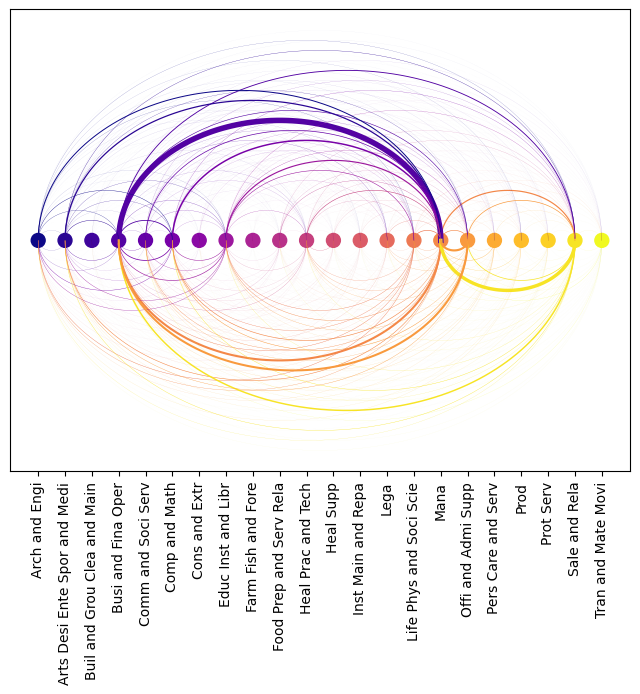

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from arcplot import ArcDiagram

def truncate_labels(label):
    return " ".join([word[:4] for word in label.split()])

# Load data
data = pd.read_csv("../data/major_occupation_transitions_y1-5.csv")
data["source"] = data["source"].apply(truncate_labels)
data["target"] = data["target"].apply(truncate_labels)

# Extract unique nodes
nodes = sorted(set(data["source"].tolist() + data["target"].tolist()))  # Sorted alphabetically

# Initialize ArcDiagram
arc_diagram = ArcDiagram(nodes, None)

# Sort nodes to establish order for positioning logic
node_order = {node: idx for idx, node in enumerate(sorted(nodes))}

# Add connections with automated arc positions
for _, row in data.iterrows():
    arc_position = "above" if node_order[row["source"]] < node_order[row["target"]] else "below"
    arc_diagram.connect(row["source"], row["target"], arc_position=arc_position, linewidth=row["value"])

# Customize appearance
arc_diagram.set_background_color("#fff")
arc_diagram.set_color_map("plasma")
arc_diagram.set_label_rotation_degree(90)

arc_diagram.show_plot()
arc_diagram.save_plot_as("../figures/arc_diagram.png", resolution=300, width=8, height=6)


# Occupation Transition Heatmap

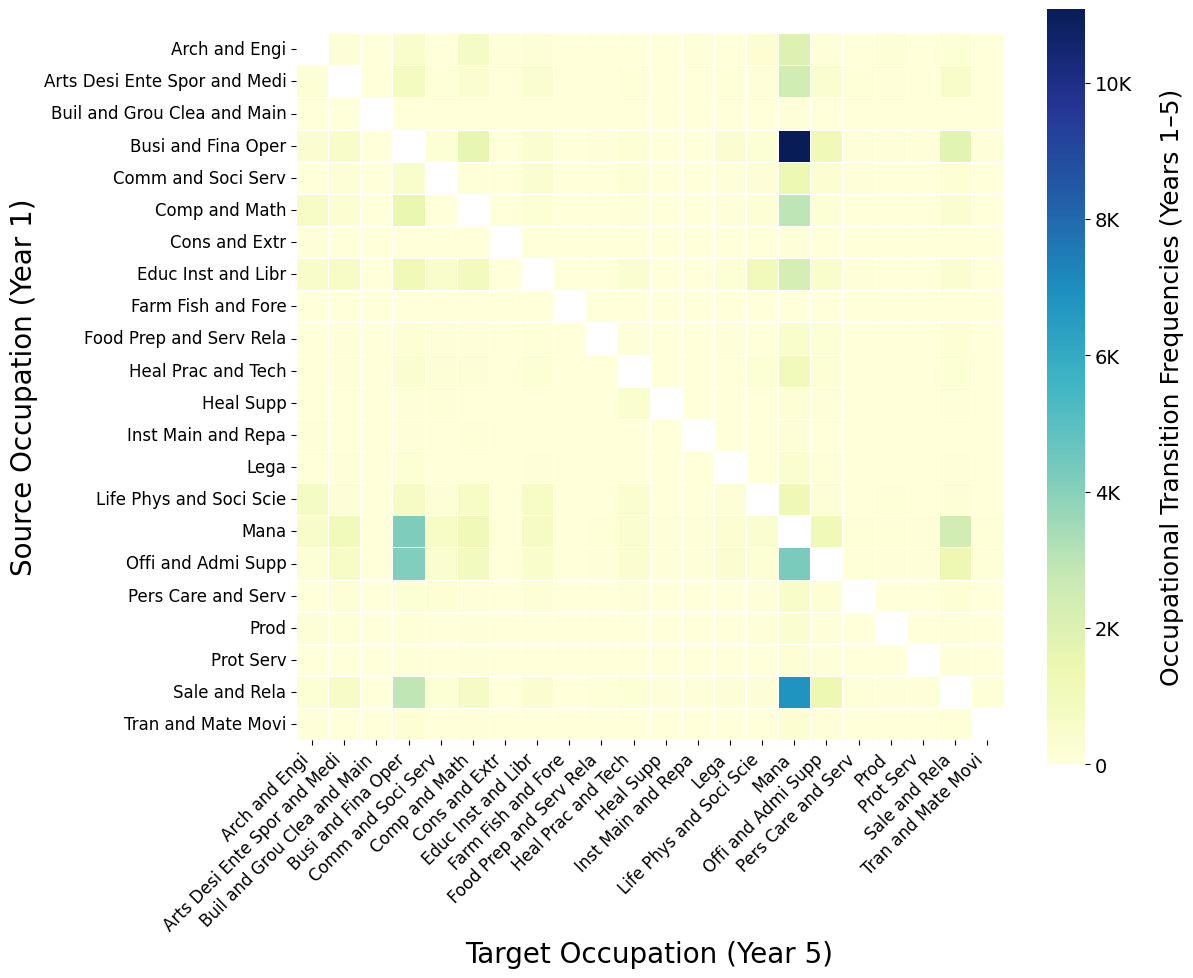

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker

# =========================
# 1. Load and preprocess data
# =========================
data = pd.read_csv("../data/major_occupation_transitions_y1-5.csv")

# Optional: truncate labels to avoid overcrowding
def truncate_labels(label):
    return " ".join([word[:4] for word in label.split()])

data["source"] = data["source"].apply(truncate_labels)
data["target"] = data["target"].apply(truncate_labels)

# Get all unique occupations
occupations = sorted(set(data["source"]).union(set(data["target"])))

# Initialize empty transition matrix
matrix = pd.DataFrame(
    0,
    index=occupations,
    columns=occupations
)

# Populate matrix with transition frequencies
for _, row in data.iterrows():
    src = row["source"]
    tgt = row["target"]
    val = row["value"]
    matrix.loc[src, tgt] += val

# =========================
# 2. Mask self-transitions (diagonal)
# =========================
mask = np.eye(len(occupations), dtype=bool)
matrix_masked = matrix.mask(mask)

# =========================
# 3. Plot heatmap
# =========================
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    matrix_masked,
    cmap="YlGnBu",
    cbar_kws={"label": "Occupational Transition Frequencies (Years 1–5)"},
    square=True,
    linewidths=0.5,
    linecolor="white",
    annot=False
)

# =========================
# 4. Customize colorbar
# =========================
cbar = heatmap.collections[0].colorbar

# Format colorbar ticks: 2000 -> 2K
def thousands_formatter(x, pos):
    if x >= 1000:
        return f"{x/1000:.0f}K"
    else:
        return f"{int(x)}"

cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    "Occupational Transition Frequencies (Years 1–5)",
    fontsize=18,
    labelpad=20  # increase space between label and colorbar
)

# =========================
# 5. Axis formatting
# =========================
plt.xticks(
    ticks=np.arange(len(occupations)) + 0.5,
    labels=occupations,
    rotation=45,
    ha="right",
    fontsize=12
)
plt.yticks(
    ticks=np.arange(len(occupations)) + 0.5,
    labels=occupations,
    rotation=0,
    fontsize=12
)

plt.xlabel("Target Occupation (Year 5)", fontsize=20)
plt.ylabel("Source Occupation (Year 1)", fontsize=20)

plt.tight_layout()
plt.show()
plt.savefig("../figures/occupation_transition_heatmap.png", dpi=300)

# =========================
# 6. Export raw transition matrix for supplemental table
# =========================

# Export full matrix (with self-transitions)
matrix.to_csv("../data/occupation_transition_matrix_y1-5.csv")

# Coefficient Plot for Main Analysis (Models 1 - 4)

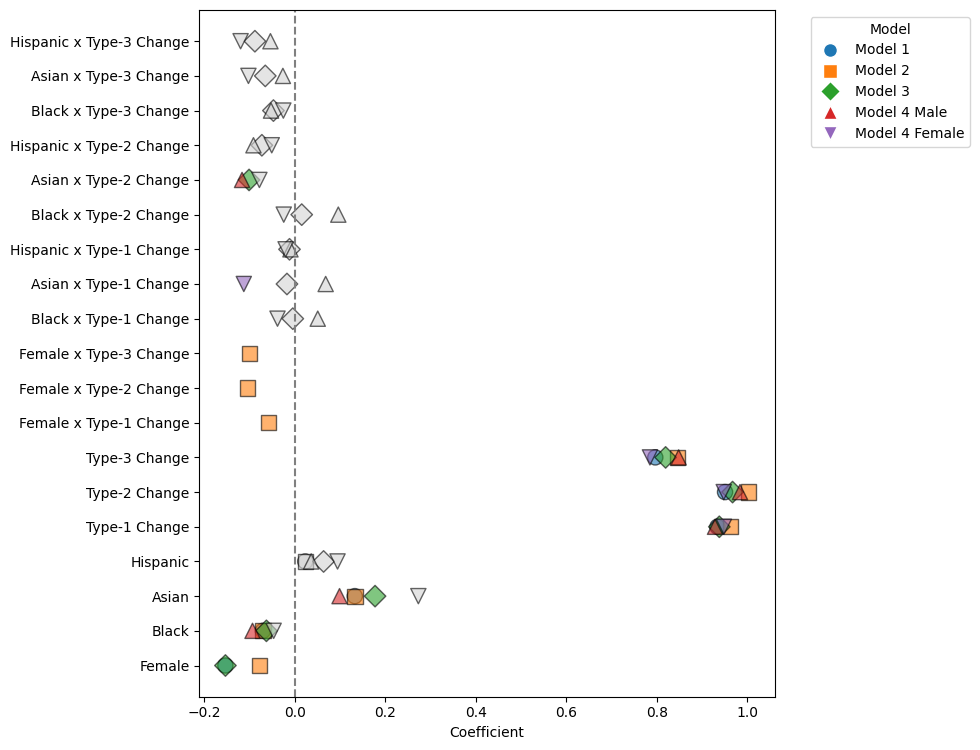

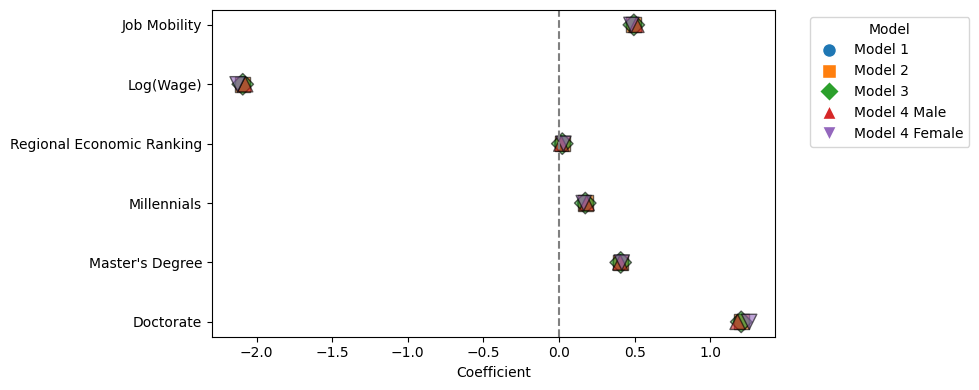

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.lines import Line2D

# =========================
# 1. Load Table 4 CSV (Models 1 - 4)
# =========================
df = pd.read_csv("../data/table4_coefficients.csv")
df = df[df['Variable'] != 'Intercept']

# =========================
# 2. Parse coefficient and significance
# =========================
def parse_coef_sig(x):
    if pd.isna(x) or x == '-':
        return (np.nan, 0)
    x_str = str(x)
    sig_level = 0
    if '*' in x_str:
        sig_level = 3  # p<0.001
    elif r'\ddagger' in x_str:
        sig_level = 2  # p<0.01
    elif r'\dagger' in x_str:
        sig_level = 1  # p<0.05
    num = float(re.sub(r'[^0-9\.-]', '', x_str))
    return (num, sig_level)

coef_cols = df.columns[1:]
for col in coef_cols:
    df[[col+'_coef', col+'_sig']] = df[col].apply(lambda x: pd.Series(parse_coef_sig(x)))

# =========================
# 3. Define main effects and covariates
# =========================
main_predictors = ['Female', 'Black', 'Asian', 'Hispanic']
type_changes = ['Type-1 Change', 'Type-2 Change', 'Type-3 Change']
interactions = [v for v in df['Variable'] if 'x' in v]
main_effects = main_predictors + type_changes + interactions

df_main = df[df['Variable'].isin(main_effects)]
df_cov = df[~df['Variable'].isin(main_effects)]

def melt_for_plot(df_subset):
    melted_list = []
    for col in coef_cols:
        coef_col = col+'_coef'
        sig_col = col+'_sig'
        temp = df_subset[['Variable', coef_col, sig_col]].copy()
        temp.rename(columns={coef_col:'Coefficient', sig_col:'SigLevel'}, inplace=True)
        temp['Model'] = col
        melted_list.append(temp)
    return pd.concat(melted_list, ignore_index=True)

df_melt_main = melt_for_plot(df_main)
df_melt_cov = melt_for_plot(df_cov)

# =========================
# 4. Define shapes and colors
# =========================
shape_dict = {
    'Model 1': 'o',
    'Model 2': 's',
    'Model 3': 'D',
    'Model 4 Male': '^',
    'Model 4 Female': 'v'
}

color_dict = {
    'Model 1': '#1f77b4',
    'Model 2': '#ff7f0e',
    'Model 3': '#2ca02c',
    'Model 4 Male': '#d62728',
    'Model 4 Female': '#9467bd'
}

# =========================
# 5. Function to plot coefficients
# =========================
def plot_coefficients(df_melt, filename, per_var_height=0.4, title=None):
    variables = df_melt['Variable'].unique()
    n_vars = len(variables)
    fig_height = max(4, n_vars * per_var_height)
    y_pos = np.arange(n_vars)
    var_to_y = {var: y for var, y in zip(variables, y_pos)}

    plt.figure(figsize=(10, fig_height))
    for model in shape_dict.keys():
        subset = df_melt[df_melt['Model'] == model].copy()
        subset['y'] = subset['Variable'].map(var_to_y)
        subset['color'] = subset.apply(lambda row: color_dict[model] if row['SigLevel']>0 else 'lightgray', axis=1)
        plt.scatter(subset['Coefficient'], subset['y'], 
                    marker=shape_dict[model], s=120, 
                    color=subset['color'], alpha=0.6, edgecolor='k')

    plt.axvline(0, color='gray', linestyle='--')
    plt.yticks(y_pos, variables)
    plt.xlabel('Coefficient')
    plt.ylabel('')
    if title:
        plt.title(title)

    # Manually create legend handles with proper colors
    legend_handles = [Line2D([0], [0], marker=shape_dict[m], color='w', 
                             markerfacecolor=color_dict[m], markersize=10, label=m) 
                      for m in shape_dict.keys()]
    plt.legend(handles=legend_handles, title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# =========================
# 6. Plot main effects
# =========================
plot_coefficients(df_melt_main, "figures/main_effects_plot.png", title=None)

# =========================
# 7. Plot covariates
# =========================
plot_coefficients(df_melt_cov, "figures/covariates_plot.png", title=None)


# Coefficient Plot for Sensitivity Analysis (1 - 4 vs. 1F - 4F)

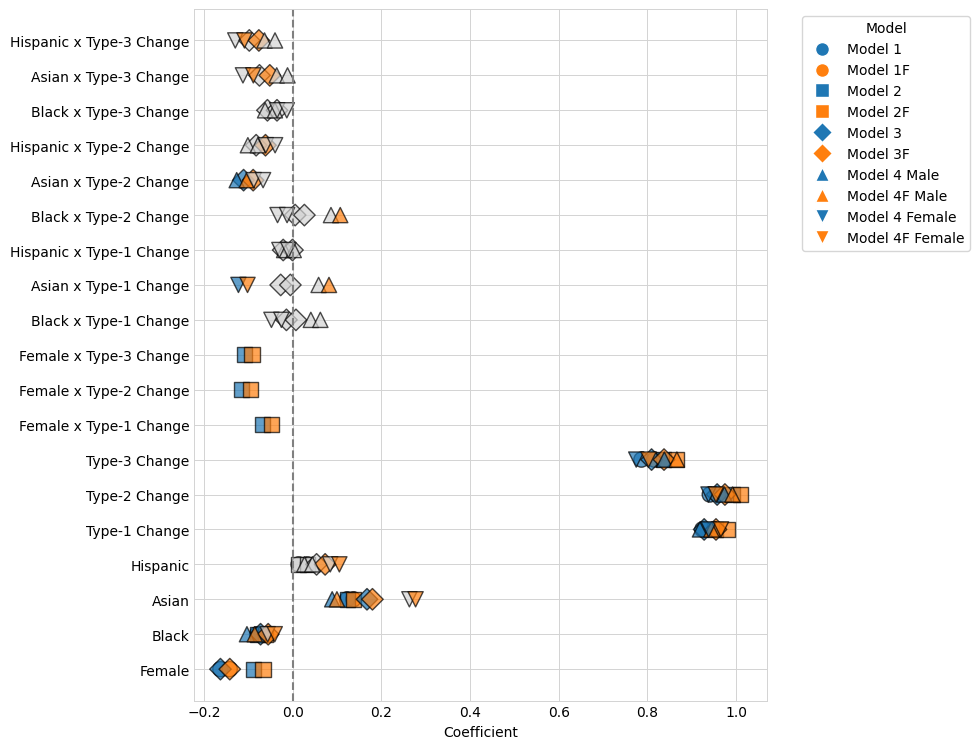

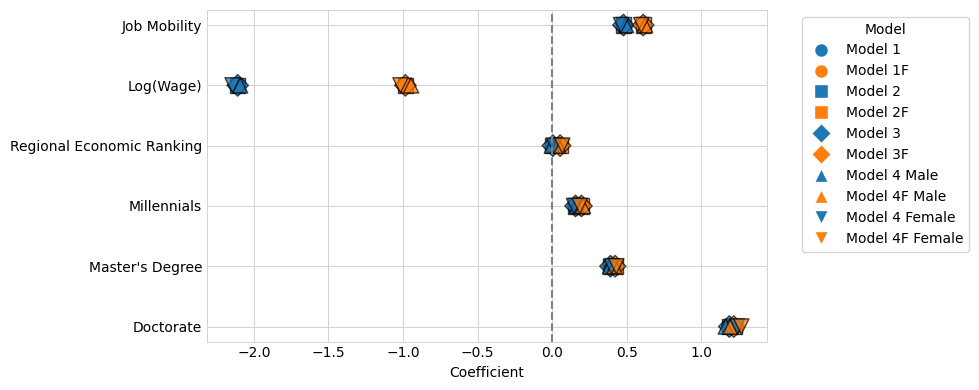

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.lines import Line2D

# =========================
# 1. Load CSV (Models 1F- 4F)
# =========================
df = pd.read_csv("../data/sensitivity_coefficients.csv")

# =========================
# 2. Parse coefficient and significance
# =========================
def parse_coef_sig(x):
    if pd.isna(x) or x == '-':
        return (np.nan, 0)
    x_str = str(x)
    sig_level = 0
    if '*' in x_str:
        sig_level = 3  # p<0.001
    elif r'\ddagger' in x_str:
        sig_level = 2  # p<0.01
    elif r'\dagger' in x_str:
        sig_level = 1  # p<0.05
    num = float(re.sub(r'[^0-9\.-]', '', x_str))
    return (num, sig_level)

coef_cols = df.columns[1:]
for col in coef_cols:
    df[[col+'_coef', col+'_sig']] = df[col].apply(lambda x: pd.Series(parse_coef_sig(x)))

# =========================
# 3. Separate main effects vs covariates
# =========================
main_predictors = ['Female', 'Black', 'Asian', 'Hispanic']
type_changes = ['Type-1 Change', 'Type-2 Change', 'Type-3 Change']
interactions = [v for v in df['Variable'] if ' x ' in v]

highlight_vars = main_predictors + type_changes + interactions

df_main = df[df['Variable'].isin(highlight_vars)]
df_cov = df[~df['Variable'].isin(highlight_vars)]

# =========================
# 4. Melt for plotting
# =========================
def melt_for_plot(df_subset):
    melted_list = []
    for col in coef_cols:
        coef_col = col+'_coef'
        sig_col = col+'_sig'
        temp = df_subset[['Variable', coef_col, sig_col]].copy()
        temp.rename(columns={coef_col:'Coefficient', sig_col:'SigLevel'}, inplace=True)
        temp['Model'] = col
        melted_list.append(temp)
    return pd.concat(melted_list, ignore_index=True)

df_melt_main = melt_for_plot(df_main)
df_melt_cov = melt_for_plot(df_cov)

# =========================
# 5. Define model pairs, shapes, colors
# =========================
model_pairs = {
    'Model 1': 'Model 1F',
    'Model 2': 'Model 2F',
    'Model 3': 'Model 3F',
    'Model 4 Male': 'Model 4F Male',
    'Model 4 Female': 'Model 4F Female'
}

shape_dict = {
    'Model 1': 'o',
    'Model 2': 's',
    'Model 3': 'D',
    'Model 4 Male': '^',
    'Model 4 Female': 'v'
}

color_dict = {
    'standard': '#1f77b4',  # blue
    'glmm': '#ff7f0e'       # orange
}

# =========================
# 6. Plotting function
# =========================
def plot_coefficients(df_melt, filename, per_var_height=0.4, title=None):
    variables = df_melt['Variable'].unique()
    n_vars = len(variables)
    fig_height = max(4, n_vars * per_var_height)
    y_pos = np.arange(n_vars)
    var_to_y = {var: y for var, y in zip(variables, y_pos)}

    plt.figure(figsize=(10, fig_height))
    ax = plt.gca()

    # Gridlines behind markers
    plt.grid(axis='x', color='lightgray', linestyle='-', linewidth=0.7)
    plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.7)
    ax.set_axisbelow(True)

    # Spines same color as gridlines
    for spine in ax.spines.values():
        spine.set_color('lightgray')
        spine.set_linewidth(0.7)

    # Hide small tick marks but keep labels
    ax.tick_params(axis='both', which='both', length=0)

    # Adaptive horizontal jitter
    coef_min = df_melt['Coefficient'].min()
    coef_max = df_melt['Coefficient'].max()
    coef_range = coef_max - coef_min
    offset = max(0.005 * coef_range, 0.01)

    for std_model, glmm_model in model_pairs.items():
        for model, color_type in zip([std_model, glmm_model], ['standard','glmm']):
            if model not in df_melt['Model'].values:
                continue
            subset = df_melt[df_melt['Model'] == model].copy()
            subset['y'] = subset['Variable'].map(var_to_y)
            subset['color'] = subset.apply(
                lambda row: color_dict[color_type] if row['SigLevel']>0 else 'lightgray', axis=1
            )

            x_plot = subset['Coefficient'] - offset if color_type=='standard' else subset['Coefficient'] + offset

            plt.scatter(x_plot, subset['y'],
                        marker=shape_dict[std_model], s=120,
                        color=subset['color'], alpha=0.7, edgecolor='k')

    plt.axvline(0, color='gray', linestyle='--')
    plt.yticks(y_pos, variables)
    plt.xlabel('Coefficient')
    plt.ylabel('')
    if title:
        plt.title(title)

    # Legend
    legend_handles = []
    for std_model, glmm_model in model_pairs.items():
        legend_handles.append(Line2D([0], [0], marker=shape_dict[std_model], color='w',
                                     markerfacecolor=color_dict['standard'], markersize=10, label=std_model))
        legend_handles.append(Line2D([0], [0], marker=shape_dict[std_model], color='w',
                                     markerfacecolor=color_dict['glmm'], markersize=10, label=glmm_model))
    plt.legend(handles=legend_handles, title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# =========================
# 7. Plot main effects
# =========================
plot_coefficients(df_melt_main, "figures/sensitivity_main_effects_plot.png", title=None)

# =========================
# 8. Plot covariates
# =========================
plot_coefficients(df_melt_cov, "figures/sensitivity_covariates_plot.png", title=None)
